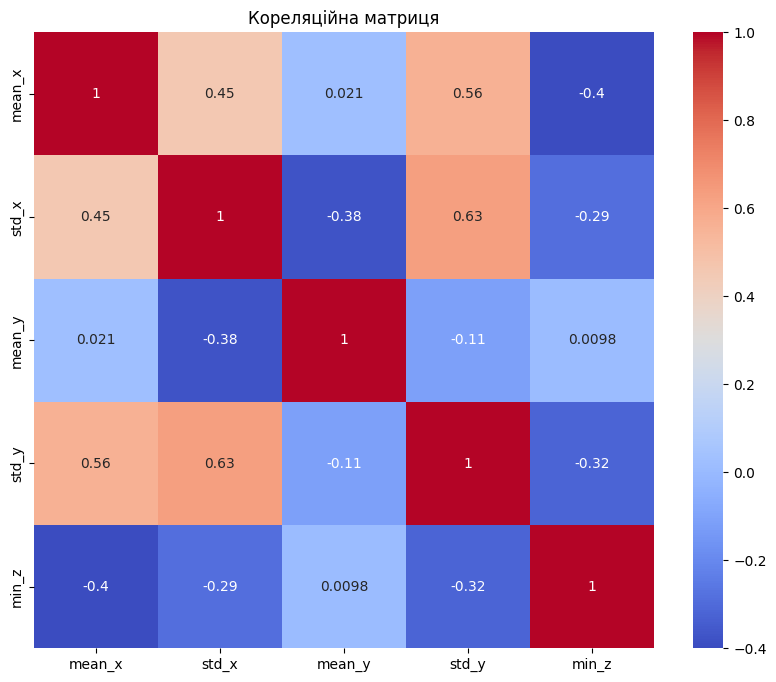

Точність SVM на обраних ознаках: 0.54


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import glob
import os

def load_all_data(folder_path):
    folder_path = os.path.abspath(folder_path)
    file_paths = glob.glob(os.path.join(folder_path, "*.csv"))
    if not file_paths:
        print(f"No CSV files found in {folder_path}")
        return {}
    
    data = {}
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        if len(parts) < 2:
            print(f"File {filename} does not match the expected naming convention.")
            continue
        activity, sensor_type = parts[0], parts[1].split('.')[0]
        key = f"{activity}_{sensor_type}"
        
        df = pd.read_csv(file_path)
        if df.empty:
            print(f"Warning: {file_path} is empty.")
        else:
            data[key] = df

    return data

def process_data(data, window_size=2, frequency=30):
    window_length = window_size * frequency
    windows = [data.iloc[i:i+window_length] for i in range(0, len(data), window_length) if len(data.iloc[i:i+window_length]) == window_length]
    stats = [compute_window_statistics(window) for window in windows]
    return pd.DataFrame(stats)

# Завантаження даних
data = load_all_data('data_folder')
if not data:
    print("No data available for processing.")
else:
    all_stats = []
    for key, current_data in data.items():
        stats = process_data(current_data)
        if not stats.empty:
            stats['activity'] = key.split('_')[0]
            stats['sensor'] = key.split('_')[1]
            all_stats.append(stats)

    if all_stats:
        df_stats = pd.concat(all_stats, ignore_index=True)

        # Підготовка даних для алгоритму SVM
        X = df_stats.drop(columns=['activity', 'sensor'])
        y = df_stats['activity']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Побудова кореляційної матриці
        selected_features = ['mean_x', 'std_x', 'mean_y', 'std_y', 'min_z']
        corr_matrix = df_stats[selected_features].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Кореляційна матриця')
        plt.show()

        # Тренування та оцінка алгоритму машинного навчання SVM
        X_svm_train = X_train[selected_features]
        X_svm_test = X_test[selected_features]

        scaler_svm = MinMaxScaler()
        X_svm_train_scaled = scaler_svm.fit_transform(X_svm_train)
        X_svm_test_scaled = scaler_svm.transform(X_svm_test)

        svm_model = SVC(kernel='linear')
        svm_model.fit(X_svm_train_scaled, y_train)

        y_svm_pred = svm_model.predict(X_svm_test_scaled)
        svm_accuracy = accuracy_score(y_test, y_svm_pred)
        print(f'Точність SVM на обраних ознаках: {svm_accuracy:.2f}')
    else:
        print("No data available for processing.")
